In [2]:
import json 
import pandas as pd
from datetime import datetime
from collections import Counter
import numpy as np 
import pylab as plt

In [3]:
with open("out.json", "r") as fdata:
    data = json.load(fdata)
data = [d for d in data if "time_start" in d]
data = [d for d in data if len(d["question_order"]) > 10 and d["id"] != "362" and d['id'] != "352"]

In [4]:
with open("../src/application/static/data/test-questions-2.json", 'r') as fdata:
    questions = json.load(fdata)

q_lookup = dict()
for q_arr in questions:
    for q in q_arr:
        q_lookup[ q["question_id"] ] = q 

q_lookup["q_0_0"]


{'q_type': 'T1',
 'q_text': 'How many neighbors of the highlighted node have degree 4?',
 'q_options': {'option-1': 1, 'option-2': 2, 'option-3': 3, 'option-4': 4},
 'graph': {'graph_type': 'eucldiean', 'graph_id': 'e_group_0'},
 'node': ['node_1'],
 'q_answer': 'option-2',
 'question_id': 'q_0_0'}

In [5]:
Q_groups = [
    [q for q in questions if q[0]["q_type"] in ["T1", "T3"]], 
    [q for q in questions if q[0]["q_type"] in ["T2", "T5"]], 
    [q for q in questions if q[0]["q_type"] in ["T4", "T6"]]
]

In [6]:
for q in Q_groups[1]:
    print(q[0]['q_type'], q[0]['graph']['graph_id'])


T2 e_group_0
T5 e_group_0
T2 e_group_1
T5 e_group_1
T2 e_group_2
T5 e_group_2
T2 h_group_0
T5 h_group_0
T2 h_group_1
T5 h_group_1
T2 h_group_2
T5 h_group_2
T2 s_group_0
T5 s_group_0
T2 s_group_1
T5 s_group_1
T2 s_group_2
T5 s_group_2


In [7]:
id_mapping = dict()
for group in Q_groups:
    for i,q in enumerate(sorted([q[0]["question_id"] for q in group])):
        num = q.split("_")[1]
        id_mapping[num] = i

print(id_mapping)

{'0': 0, '12': 1, '14': 2, '18': 3, '20': 4, '24': 5, '26': 6, '2': 7, '30': 8, '32': 9, '36': 10, '38': 11, '42': 12, '44': 13, '48': 14, '50': 15, '6': 16, '8': 17, '10': 0, '13': 1, '16': 2, '19': 3, '1': 4, '22': 5, '25': 6, '28': 7, '31': 8, '34': 9, '37': 10, '40': 11, '43': 12, '46': 13, '49': 14, '4': 15, '52': 16, '7': 17, '11': 0, '15': 1, '17': 2, '21': 3, '23': 4, '27': 5, '29': 6, '33': 7, '35': 8, '39': 9, '3': 10, '41': 11, '45': 12, '47': 13, '51': 14, '53': 15, '5': 16, '9': 17}


In [8]:
task_dict = {
    "T1": list(),
    "T2": list(),
    "T3": list(), 
    "T4": list(), 
    "T5": list(), 
    "T6": list()
}

In [9]:
def create_entry(entry):
    new_res = dict()

    new_res["q_group"] = entry["q_group"]
    new_res["totalTime"] = (datetime.fromisoformat(entry["time_end"]) - datetime.fromisoformat(entry["time_start"])).seconds / 60
    for geo in ["E", "H", "S"]:
        for qid in sorted(entry["results"][geo].keys()):

            res = entry["results"][geo][qid]
            question = q_lookup[qid]

            tmp_res = dict()

            qnum = id_mapping[ qid.split("_")[1] ]
            tmp_res[f"graph_{geo}-q_{qnum}"] = question['graph']['graph_id']
            tmp_res[f"type_{geo}-q_{qnum}"]  =  question["q_type"]
            tmp_res[f"{geo}-q_{qnum}"] = res if res else "NA"   
            tmp_res[f"correct_{geo}-q_{qnum}"] = int(res == question["q_answer"])
            tmp_res[f"trueAnswer_{geo}-q_{qnum}"] = question["q_answer"]

            res_num = int(res.split("-")[1])
            ans_num = int(question["q_answer"].split("-")[1])
            tmp_res[f"editDist_{geo}-q_{qnum}"] = 1 - (abs(res_num-ans_num) / 3)

            interactions = json.loads(entry["interaction_list"][geo][qid])

            stime = int(interactions[0]["time"])
            etime = int(interactions[-1]["time"])
            tmp_res[f"time_{geo}-q_{qnum}"] = etime - stime
            counts = Counter([event["event"] for event in interactions if event["event"] != "start" and event["event"] != "end"])
            for event in ["hover", "pan", "zoom", "dblclick", "reset"]:
                tmp_res[f"{event}Count_{geo}-q_{qnum}"] = counts[event]

            new_res |= tmp_res

            tmp_res['id'] = entry['id']
            task_dict[question["q_type"]].append(tmp_res)
                

    for geo in ["E", "H", "S"]:
        likertFeedback = json.loads(entry["likert-feedback"][geo])        
        for lq_num, lq_res in likertFeedback.items():
            new_res[f"likert_{geo}_{lq_num}"] = lq_res

    txtFeedback = json.loads(entry["feedback"])
    # print(entry["feedback"])
    new_res["geom_order"] = ",".join(s for s in entry["geometry"])
    for fdbk in txtFeedback.keys():
        new_res[f"feedback-{fdbk}"] = txtFeedback[f"{fdbk}"]
        # print(txtFeedback[fdbk])
    
    return new_res 

In [10]:
entries = [e for e in data if datetime.fromisoformat(e["time_start"]) > datetime(2024, 3, 12, 10)]
results = dict()
for i,entry in enumerate(entries):
    results[f"p_{entry['id']}"] = create_entry(entry)


In [11]:
task_dict["T1"]

[{'graph_E-q_0': 'e_group_0',
  'type_E-q_0': 'T1',
  'E-q_0': 'option-2',
  'correct_E-q_0': 1,
  'trueAnswer_E-q_0': 'option-2',
  'editDist_E-q_0': 1.0,
  'time_E-q_0': 15377,
  'hoverCount_E-q_0': 10,
  'panCount_E-q_0': 0,
  'zoomCount_E-q_0': 0,
  'dblclickCount_E-q_0': 0,
  'resetCount_E-q_0': 0,
  'id': '325'},
 {'graph_E-q_1': 'e_group_2',
  'type_E-q_1': 'T1',
  'E-q_1': 'option-2',
  'correct_E-q_1': 1,
  'trueAnswer_E-q_1': 'option-2',
  'editDist_E-q_1': 1.0,
  'time_E-q_1': 14364,
  'hoverCount_E-q_1': 9,
  'panCount_E-q_1': 0,
  'zoomCount_E-q_1': 0,
  'dblclickCount_E-q_1': 0,
  'resetCount_E-q_1': 0,
  'id': '325'},
 {'graph_E-q_3': 'h_group_0',
  'type_E-q_3': 'T1',
  'E-q_3': 'option-2',
  'correct_E-q_3': 1,
  'trueAnswer_E-q_3': 'option-2',
  'editDist_E-q_3': 1.0,
  'time_E-q_3': 23933,
  'hoverCount_E-q_3': 15,
  'panCount_E-q_3': 0,
  'zoomCount_E-q_3': 0,
  'dblclickCount_E-q_3': 0,
  'resetCount_E-q_3': 0,
  'id': '325'},
 {'graph_E-q_5': 'h_group_1',
  'type_

In [12]:
df = pd.DataFrame(results)
df = df.transpose()


In [13]:
df["totalTime"].mean()

44.86666666666667

In [14]:
df[[col for col in df.columns if "time" in col]].sum(axis=1) / 1000

p_325     987.474
p_328    1355.247
p_329    1146.239
p_330     1123.04
p_335     1209.41
p_336    1404.276
p_337    1277.062
p_338     831.979
p_339    1353.743
p_341     1949.45
p_342    2141.875
p_343    1099.936
p_347    1617.192
p_348     824.316
p_349    1190.093
p_350     953.775
p_351    3157.854
p_358    1873.451
p_359    1717.879
p_363    1766.781
p_369    1215.007
p_370    1563.878
p_371    1357.662
p_372    1139.521
p_376    1303.728
p_378    1185.641
p_382    2619.955
p_385    1037.787
p_387    3972.323
p_397    1153.684
p_400     847.513
p_404    2377.833
dtype: object

In [15]:
print(df.head())
df.to_csv("out.csv")

      q_group  totalTime graph_E-q_0 type_E-q_0     E-q_0 correct_E-q_0  \
p_325       0       25.2   e_group_0         T1  option-2             1   
p_328       1       32.2   e_group_1         T5  option-2             1   
p_329       2  24.533333   e_group_1         T6  option-3             0   
p_330       1  28.033333   e_group_1         T5  option-2             1   
p_335       1       31.8   e_group_1         T5  option-3             1   

      trueAnswer_E-q_0 editDist_E-q_0 time_E-q_0 hoverCount_E-q_0  ...  \
p_325         option-2            1.0      15377               10  ...   
p_328         option-2            1.0      53538                2  ...   
p_329         option-2       0.666667       6331                5  ...   
p_330         option-2            1.0      25511                6  ...   
p_335         option-3            1.0      18258               14  ...   

      likert_S_lq-8 geom_order feedback-fq5 feedback-fq6 feedback-fq7  \
p_325             4      H,S,E 

In [16]:
times = df.filter([lab for lab in df.columns if "time" in lab], axis=1)
# times.astype(np.float64)
# times.dropna(axis=1)
times.head()
times.to_csv('times.csv')
print(times.head())

      time_E-q_0 time_E-q_1 time_E-q_2 time_E-q_3 time_E-q_4 time_E-q_5  \
p_325      15377      14364       7534      23933      13374      30188   
p_328      53538     396276      25074      15893      30364      16702   
p_329       6331      26561      14940       9130      30645      21020   
p_330      25511      14556      20156      42990      21301      92092   
p_335      18258      15404      18887      16048       8819      83953   

      time_E-q_6 time_E-q_7 time_E-q_8 time_E-q_9  ... time_S-q_8 time_S-q_9  \
p_325      18071       7240       8559      11492  ...      15055      16736   
p_328      20122      17740       9651      10230  ...       8413      14189   
p_329      14101      41401      14431      16452  ...      15778       4494   
p_330      18176      32665       7736      17518  ...      18368      12943   
p_335      25160      13538       8102      13156  ...       4789      13266   

      time_S-q_10 time_S-q_11 time_S-q_12 time_S-q_13 time_S-q_14 ti

In [17]:
correct = df.filter([lab for lab in df.columns if "correct" in lab], axis=1)
correct.head()

,correct_E-q_0,correct_E-q_1,correct_E-q_2,correct_E-q_3,correct_E-q_4,correct_E-q_5,correct_E-q_6,correct_E-q_7,correct_E-q_8,correct_E-q_9,...,correct_S-q_8,correct_S-q_9,correct_S-q_10,correct_S-q_11,correct_S-q_12,correct_S-q_13,correct_S-q_14,correct_S-q_15,correct_S-q_16,correct_S-q_17
p_325,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
p_328,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
p_329,0,1,0,1,0,0,1,0,1,1,...,1,1,0,1,0,0,1,0,0,0
p_330,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
p_335,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [18]:
correct.mean(axis=1)

p_325    0.925926
p_328    0.888889
p_329    0.537037
p_330    0.981481
p_335    0.981481
p_336    0.925926
p_337    0.962963
p_338    0.981481
p_339    0.648148
p_341    0.944444
p_342    0.777778
p_343    0.796296
p_347    0.962963
p_348     0.87037
p_349    0.759259
p_350    0.907407
p_351         1.0
p_358    0.759259
p_359    0.907407
p_363    0.777778
p_369    0.666667
p_370    0.574074
p_371    0.944444
p_372     0.87037
p_376    0.611111
p_378    0.962963
p_382    0.888889
p_385     0.87037
p_387    0.481481
p_397    0.944444
p_400    0.685185
p_404    0.296296
dtype: object

In [19]:
len(correct)

32

In [20]:
correct.columns

Index(['correct_E-q_0', 'correct_E-q_1', 'correct_E-q_2', 'correct_E-q_3',
       'correct_E-q_4', 'correct_E-q_5', 'correct_E-q_6', 'correct_E-q_7',
       'correct_E-q_8', 'correct_E-q_9', 'correct_E-q_10', 'correct_E-q_11',
       'correct_E-q_12', 'correct_E-q_13', 'correct_E-q_14', 'correct_E-q_15',
       'correct_E-q_16', 'correct_E-q_17', 'correct_H-q_0', 'correct_H-q_1',
       'correct_H-q_2', 'correct_H-q_3', 'correct_H-q_4', 'correct_H-q_5',
       'correct_H-q_6', 'correct_H-q_7', 'correct_H-q_8', 'correct_H-q_9',
       'correct_H-q_10', 'correct_H-q_11', 'correct_H-q_12', 'correct_H-q_13',
       'correct_H-q_14', 'correct_H-q_15', 'correct_H-q_16', 'correct_H-q_17',
       'correct_S-q_0', 'correct_S-q_1', 'correct_S-q_2', 'correct_S-q_3',
       'correct_S-q_4', 'correct_S-q_5', 'correct_S-q_6', 'correct_S-q_7',
       'correct_S-q_8', 'correct_S-q_9', 'correct_S-q_10', 'correct_S-q_11',
       'correct_S-q_12', 'correct_S-q_13', 'correct_S-q_14', 'correct_S-q_15',
   

In [21]:
EuclideanCols = [col for col in correct.columns if "H" in col]
EuclideanColsInE = [col for col in EuclideanCols if 6 <= int(col.split("_")[2]) < 12]
EuclideanColsOutE = [col for col in EuclideanCols if col not in EuclideanColsInE]
EuclideanColsOutE

['correct_H-q_0',
 'correct_H-q_1',
 'correct_H-q_2',
 'correct_H-q_3',
 'correct_H-q_4',
 'correct_H-q_5',
 'correct_H-q_12',
 'correct_H-q_13',
 'correct_H-q_14',
 'correct_H-q_15',
 'correct_H-q_16',
 'correct_H-q_17']

In [22]:
within_dist = correct[EuclideanColsInE].mean(axis=1)

In [23]:
without_dist = correct[EuclideanColsOutE].mean(axis=1)

In [24]:
without_dist

p_325    0.916667
p_328    0.916667
p_329        0.75
p_330         1.0
p_335         1.0
p_336         1.0
p_337         1.0
p_338         1.0
p_339         0.5
p_341         1.0
p_342        0.75
p_343        0.75
p_347         1.0
p_348    0.916667
p_349    0.666667
p_350         1.0
p_351         1.0
p_358    0.833333
p_359        0.75
p_363    0.916667
p_369    0.583333
p_370        0.75
p_371    0.916667
p_372    0.833333
p_376    0.583333
p_378         1.0
p_382         1.0
p_385    0.833333
p_387    0.666667
p_397    0.916667
p_400    0.333333
p_404        0.25
dtype: object

In [25]:
H1 = pd.DataFrame()
H1["H_within"] = within_dist
H1["H_without"] = without_dist
H1.to_csv("hyperbolic_hypothesis1.csv")

In [26]:
from scipy.stats import ks_2samp

In [27]:
ks_2samp(within_dist.to_numpy(), without_dist.to_numpy())

KstestResult(statistic=0.25, pvalue=0.2730080624498207, statistic_location=0.6666666666666666, statistic_sign=1)

In [28]:
Euc = correct[[col for col in correct.columns if "E" in col]]
Hyp = correct[[col for col in correct.columns if "H" in col]]
Sph = correct[[col for col in correct.columns if "S" in col]]


In [29]:
Euc_avg = Euc.mean(axis=1)
Hyp_avg = Hyp.mean(axis=1)
Sph_avg = Sph.mean(axis=1)

In [30]:
overall_avg = pd.DataFrame()
overall_avg["E_avg"] = Euc_avg
overall_avg["H_avg"] = Hyp_avg
overall_avg["S_avg"] = Sph_avg

In [31]:
overall_avg.head()
overall_avg.to_csv("overall_avg.csv")

In [32]:
df.head()
df.loc["p_325"]["totalTime"]

25.2

In [33]:
group_0 = df.loc[df['q_group'] == 0]
task_groups = {"T1": list(), "T3": list()}
for gtype, task in group_0[[col for col in group_0.columns if "type" in col]].iloc[0].to_dict().items():
    task_groups[task].append(gtype)


In [34]:
T1_num = [s[-5:] for s in task_groups["T1"]]
columns = [col for t in T1_num for col in df.columns if t in col]
T1 = group_0[columns]
T1.to_csv("hypotheses/out_T1.csv")

In [35]:
T3_num = [s[-5:] for s in task_groups["T3"]]
columns = [col for t in T3_num for col in df.columns if t in col]
T3 = group_0[columns]
T3.to_csv("hypotheses/out_T3.csv")

In [36]:
group_1 = df.loc[df['q_group'] == 1]
task_groups = {"T2": list(), "T5": list()}
for gtype, task in group_1[[col for col in group_0.columns if "type" in col]].iloc[0].to_dict().items():
    task_groups[task].append(gtype)

In [37]:
T2_num = [s[-5:] for s in task_groups["T2"]]
columns = [col for t in T2_num for col in df.columns if t in col]
T2 = group_1[columns]
T2.to_csv("hypotheses/out_T2.csv")

In [38]:
T5_num = [s[-5:] for s in task_groups["T5"]]
columns = [col for t in T5_num for col in df.columns if t in col]
T5 = group_1[columns]
T5.to_csv("hypotheses/out_T5.csv")

In [39]:
group_2 = df.loc[df['q_group'] == 2]
task_groups = {"T4": list(), "T6": list()}
for gtype, task in group_2[[col for col in group_2.columns if "type" in col]].iloc[0].to_dict().items():
    task_groups[task].append(gtype)

In [40]:
T4_num = [s[-5:] for s in task_groups["T4"]]
columns = [col for t in T4_num for col in df.columns if t in col]
T4 = group_2[columns]
T4.to_csv("hypotheses/out_T4.csv")

In [41]:
T6_num = [s[-5:] for s in task_groups["T6"]]
columns = [col for t in T6_num for col in df.columns if t in col]
T6 = group_2[columns]
T6.to_csv("hypotheses/out_T6.csv")

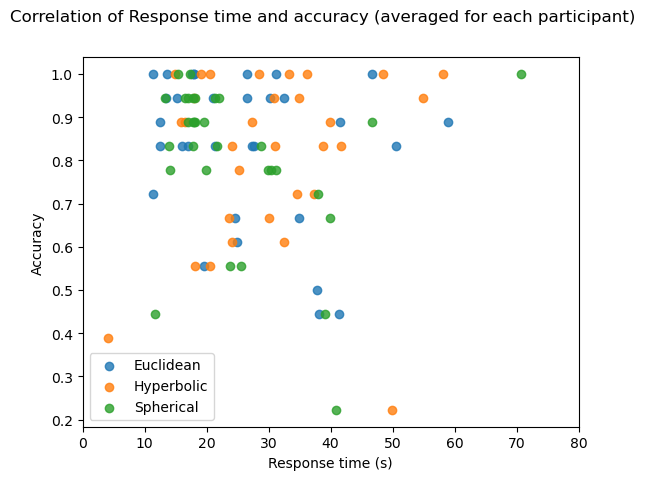

In [43]:
E_time = df[[col for col in df.columns if "time_E" in col]].mean(axis=1).to_numpy().flatten() / 1000
E_acc = df[[col for col in df.columns if "correct_E" in col]].mean(axis=1).to_numpy().flatten() 
H_time = df[[col for col in df.columns if "time_H" in col]].mean(axis=1).to_numpy().flatten() / 1000
H_acc = df[[col for col in df.columns if "correct_H" in col]].mean(axis=1).to_numpy().flatten()
S_time = df[[col for col in df.columns if "time_S" in col]].mean(axis=1).to_numpy().flatten() / 1000
S_acc = df[[col for col in df.columns if "correct_S" in col]].mean(axis=1).to_numpy().flatten()
plt.scatter(E_time, E_acc,alpha=0.8, label="Euclidean")
plt.scatter(H_time, H_acc, alpha=0.8, label="Hyperbolic")
plt.scatter(S_time, S_acc, alpha=0.8, label="Spherical")
plt.legend()
plt.xlim(0,80)
plt.xlabel("Response time (s)")
plt.ylabel("Accuracy")
plt.suptitle("Correlation of Response time and accuracy (averaged for each participant)")
plt.savefig("figures/correlation-all.pdf")

import sklearn 


In [44]:
print("Euclidean correlation is ", np.corrcoef(E_time, E_acc)[0,1])
print("Hyperbolic correlation is ", np.corrcoef(H_time, H_acc)[0,1])
print("Spherical correlation is ", np.corrcoef(S_time, S_acc)[0,1])

AttributeError: 'float' object has no attribute 'shape'

In [45]:
np.corrcoef(np.concatenate((E_time, H_time, S_time)), np.concatenate((E_acc, H_acc, S_acc)))[0,1]

AttributeError: 'float' object has no attribute 'shape'

In [46]:
for index, row in df.iterrows():
    print("------------------")
    print()
    print(row['geom_order'])
    print()
    print(row["feedback-fq1"])
    print()
    print(row['feedback-fq2'])
    print()
    print(row['feedback-fq4'])
    print()
    print()

------------------

H,S,E

hovering over nodes to see where to go next when counting length between nodes. trying to count carefully

no

i hated the first style. the globe and flat styles were comparable, but i would never want to use the first one


------------------

E,S,H

The hover ability was most valuable for all three visualization techniques, both allowing me to count numbers of edges and nodes (I'm assuming each pair of nodes has at most one edge between them). Quickly moving the mouse between two nodes was a good way to discover the intersection of their neighbors.

No

The second visualization technique was particularly frustrating because in some circumstances it started the view with much of the graph hidden, including the "highlighted" nodes. In practice it would make sense for a visualization technique like this to start with the highlighted nodes (or at least the center of the graph) visible for the user.


------------------

H,E,S








------------------

E,H,S

